In [2]:
import datetime
import yfinance as yf
import statsmodels.tsa.stattools as sm
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/home/mmelnik1/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mmelnik1/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/mmelnik1/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection i

In [174]:
stock = 'aapl'
train_start = '2020-01-01'
train_end = pd.Timestamp('2023-10-31', tz='America/New_York')
sim_start = '2023-10-30'
sim_end = pd.Timestamp('2023-12-31', tz='America/New_York')
scen_size = 10000

In [28]:
ticker = yf.Ticker('aapl')

In [168]:
train_set = ticker.history(start=train_start, end=train_end)['Close']

In [169]:
test_set = ticker.history(start=sim_start, end=sim_end)['Close']

In [170]:
s0 = train_set.iloc[-1]
dt = 1

In [171]:
test_set

Date
2023-10-30 00:00:00-04:00    169.619141
2023-10-31 00:00:00-04:00    170.097275
2023-11-01 00:00:00-04:00    173.284668
2023-11-02 00:00:00-04:00    176.870483
2023-11-03 00:00:00-04:00    175.954086
2023-11-06 00:00:00-05:00    178.523926
2023-11-07 00:00:00-05:00    181.103729
2023-11-08 00:00:00-05:00    182.169510
2023-11-09 00:00:00-05:00    181.691422
2023-11-10 00:00:00-05:00    185.910278
2023-11-13 00:00:00-05:00    184.314484
2023-11-14 00:00:00-05:00    186.947556
2023-11-15 00:00:00-05:00    187.516052
2023-11-16 00:00:00-05:00    189.211609
2023-11-17 00:00:00-05:00    189.191650
2023-11-20 00:00:00-05:00    190.947021
2023-11-21 00:00:00-05:00    190.139145
2023-11-22 00:00:00-05:00    190.807404
2023-11-24 00:00:00-05:00    189.470901
2023-11-27 00:00:00-05:00    189.291367
2023-11-28 00:00:00-05:00    189.899765
2023-11-29 00:00:00-05:00    188.872482
2023-11-30 00:00:00-05:00    189.450958
2023-12-01 00:00:00-05:00    190.737579
2023-12-04 00:00:00-05:00    188.93

In [172]:
train_set

Date
2020-01-02 00:00:00-05:00     72.960457
2020-01-03 00:00:00-05:00     72.251129
2020-01-06 00:00:00-05:00     72.826881
2020-01-07 00:00:00-05:00     72.484352
2020-01-08 00:00:00-05:00     73.650337
                                ...    
2023-10-24 00:00:00-04:00    172.756744
2023-10-25 00:00:00-04:00    170.425964
2023-10-26 00:00:00-04:00    166.232529
2023-10-27 00:00:00-04:00    167.557297
2023-10-30 00:00:00-04:00    169.619141
Name: Close, Length: 964, dtype: float64

In [175]:
n_of_wkdays = pd.date_range(start=pd.to_datetime(train_end,
                                                 format="%Y-%m-%d") + pd.Timedelta('1 days'),
                            end=pd.to_datetime(sim_end,
                                               format="%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()
T = n_of_wkdays

In [176]:
N = T / dt
t = np.arange(1, N + 1)

In [177]:
daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]
mu = daily_returns.mean()

In [178]:
sigma = np.std(daily_returns)

In [179]:
b = {str(scen): np.random.normal(0,1, int(N)) for scen in range(1, scen_size + 1)}

In [180]:
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

In [181]:
drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

In [182]:
S = np.array([s0 * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
S = np.hstack((np.array([[s0] for scen in range(1, scen_size + 1)]), S))

In [194]:
p = len(pd.date_range(start=train_set.index[-1],
                           end=sim_end,
                           freq='D').map(lambda x: x if x.isoweekday() in range(1, 6) else np.nan).dropna())

In [187]:
len(S[0])

44

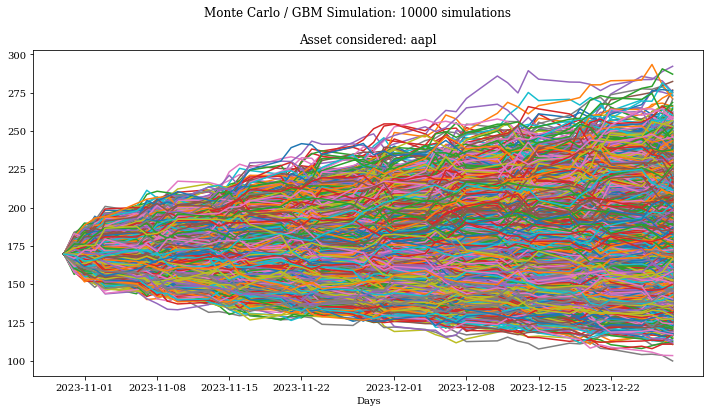

In [190]:
#fig, ax = plt.subplots()
plt.rcParams["font.family"] = "serif"
plt.figure(figsize=(12,6))
plt.suptitle('Monte Carlo / GBM Simulation: ' +  str(scen_size) + ' simulations')
plt.title('Asset considered: ' + stock)
plt.xlabel('Days')


for i in range(scen_size):
    plt.plot(pd.date_range(start=train_set.index[-1],
                           end=sim_end,
                           freq='D').map(lambda x: x if x.isoweekday() in range(1, 6) else np.nan).dropna()[:p-1], S[i])

plt.show()

In [191]:
S_max = [S[:,i].max() for i in range(int(N))]
S_min = [S[:,i].min() for i in range(int(N))]
S_avg = 0.5 * np.array(S_max) + 0.5 *  np.array(S_min)
final_df = pd.DataFrame(data=[test_set.reset_index()['Close'], S_avg],
                              index=['real', 'pred']).T
final_df.index = test_set.index

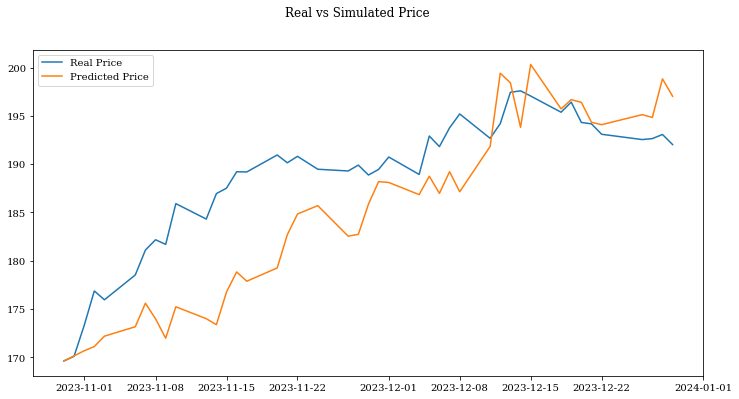

In [193]:
plt.figure(figsize=(12,6))
plt.suptitle('Real vs Simulated Price')
plt.plot(final_df)
plt.legend(['Real Price', 'Predicted Price'])
plt.show()